In [ ]:
#Download the data
!wget https://biodynamics.ucsd.edu/wp-content/uploads/2020/08/features_targets_loadingrecord.zip
#Create a new folder for the data
!mkdir data_chem
#Unzip the data
!unzip features_targets_loadingrecord -d data_chem/
!rm features_targets_loadingrecord.zip
!echo "data_chem/" >> .gitignore

In [15]:
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data loading

This section downloads the data prepares it for the data-preprocessing step. The last step before preprocessing combines duplicated genes by taking their average.

In [3]:
#Load the matrix with all the data
data_full = pd.read_csv("./data_chem/features.csv")
#Load induction time profiles
u_ts = pd.read_csv("./data_chem/targets.csv")
#Load genes
genes = pd.read_csv("./data_chem/loading_record.csv")

In [4]:
#List and print all experiments
exp_id = data_full.exp_id.unique()
# print(exp_id)

#Select the experiment
exp_of_interest = 1 #this selects the first experiment only

#Subselecting data for the experiment of interest
df_exp = data_full[data_full.exp_id == exp_id[exp_of_interest-1]].drop(columns=["Unnamed: 1", "exp_id"])

#Renaming columns
df_exp.columns = genes.gene_name

#Filtering out spots with no strain averaging duplicate genes
df_exp=df_exp.iloc[:,df_exp.columns.notna()]

In [6]:
# This section extracts the input profile
# Display the unique values in the "induction_state" column
u_ts = deepcopy(u_ts[u_ts.exp_id == exp_id[exp_of_interest-1]])

unique_induction_states = u_ts["induction_state"].unique()

# Define a mapping for encoding of u_ts
encoding_map = {
    "('MilliQ_ddH2O',)": 0,
}

# Assign subsequent integers to other unique values
for idx, state in enumerate(unique_induction_states, start=0):
    if state not in encoding_map:
        encoding_map[state] = idx

u_ts["induction_state_encoded"] = u_ts["induction_state"].map(encoding_map)


# Create a dictionary to store start and end indices for each induction state occurrence
induction_intervals = {}

# Initialize variables to keep track of the current state and its start index
current_state = None
start_index = None

# Loop through rows in the DataFrame
for idx, row in u_ts.iterrows():
    state = row["induction_state"]
    
    # If we encounter a new state or reach the end of the DataFrame
    if current_state != state or idx == u_ts.index[-1]:
        # If we were tracking a state, save its interval (except for the first iteration)
        if current_state is not None:
            # Adjust end index for the last entry in the DataFrame
            end_index = idx if idx == u_ts.index[-1] and current_state == state else idx - 1
            if current_state in induction_intervals:
                induction_intervals[current_state].append((start_index, end_index))
            else:
                induction_intervals[current_state] = [(start_index, end_index)]
        
        # Start tracking the new state
        current_state = state
        start_index = idx

induction_intervals

{"('MilliQ_ddH2O',)": [(0, 107), (132, 371), (396, 638), (664, 789)],
 "('Cd(II)',)": [(108, 131), (639, 663)],
 "('Pb(II)',)": [(372, 395)]}

In [5]:
# stimulus_of_interest = 1 #This is selecting the first "kick" only

# # This block identified start and end time of each stimulus (i.e. whenever the same stimulus has been applied > 1x in an experiment it allows to subselect "duplicates")

# start_time = [i[0] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]
# end_time = [i[1] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]

# df_exp = deepcopy(df_exp.iloc[start_time[0]:end_time[0]+1,:])
# df_exp.shape

(790, 1995)

In [7]:
#In the original dataset there are several "biological replicates", i.e. spots of the chip where the same gene is tracked
#This snippet of code averages all these spots to obtain a final dataset with one column per gene
duplicated_columns = df_exp.columns[df_exp.columns.duplicated(keep=False)].unique()

for i in duplicated_columns:
    print("The gene ",i, " has ", df_exp[i].shape[1], " spots associated to it (biological replicates)")

# Create a new DataFrame to store the results
df_result = pd.DataFrame()

# Process non-duplicated columns
for column in df_exp.columns:
    if column not in duplicated_columns:
        df_result[column] = df_exp[column]

# Process duplicated columns
for dup_col in duplicated_columns:
    # Take the average of duplicated columns and assign to the result DataFrame
    df_result[dup_col] = df_exp[dup_col].mean(axis=1)

df_result.head()

The gene  zntA  has  15  spots associated to it (biological replicates)
The gene  rpoS  has  15  spots associated to it (biological replicates)
The gene  cueO  has  15  spots associated to it (biological replicates)
The gene  rpoH  has  15  spots associated to it (biological replicates)
The gene  wrbA  has  21  spots associated to it (biological replicates)
The gene  rpoD  has  15  spots associated to it (biological replicates)
The gene  fimD  has  15  spots associated to it (biological replicates)
The gene  lacZ  has  22  spots associated to it (biological replicates)
The gene  yacH  has  2  spots associated to it (biological replicates)
The gene  U66  has  20  spots associated to it (biological replicates)
The gene  serA  has  21  spots associated to it (biological replicates)
The gene  U139  has  20  spots associated to it (biological replicates)
The gene  tdcG_2  has  2  spots associated to it (biological replicates)
The gene  infA  has  3  spots associated to it (biological replic

/tmp/ipykernel_477/3742261841.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_result[column] = df_exp[column]
/tmp/ipykernel_477/3742261841.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_result[dup_col] = df_exp[dup_col].mean(axis=1)


,rihC,ypfH,alsI,ygdQ,yabP,ypfJ,talB,yqeI,yabI,hda,...,rpoD,fimD,lacZ,yacH,U66,serA,U139,tdcG_2,infA,yebF
0,-0.022629,0.148508,-0.088955,-0.232066,0.069350,-0.644056,-0.030329,-0.020271,0.158288,1.246769,...,-0.084612,-0.012124,-0.064123,-0.065857,-0.063226,2.938553,-0.079553,-0.094431,-3.164757,-0.242952
1,-0.075618,-0.191642,-0.041127,0.221798,0.114038,-0.554063,-0.029043,0.117677,0.020580,1.160078,...,-0.051237,-0.009570,-0.067436,-0.047152,-0.096200,3.144924,-0.022218,-0.034728,-1.831284,0.094008
2,0.053473,0.146480,-0.111173,0.138315,0.002590,-0.147216,-0.113246,-0.030373,0.089998,1.312099,...,-0.020321,-0.031348,-0.067067,0.027820,-0.080628,3.385740,-0.017088,-0.034646,-3.035438,-0.126263
3,-0.137537,-0.224630,-0.055299,0.019529,0.085433,-0.508369,0.011168,-0.104683,0.235458,0.657336,...,-0.018129,-0.012545,-0.007957,-0.086683,-0.067020,2.658177,-0.048128,-0.101937,-2.332679,0.168084
4,-0.001089,0.149665,0.019627,0.292656,-0.153317,-0.116954,-0.076620,-0.048036,0.044441,1.461989,...,-0.072185,-0.016076,-0.097118,-0.055341,-0.110282,2.639522,-0.048160,-0.161916,-1.510021,0.566953


In [9]:
# #Saving THE experiment selected to a csv file
df_result.to_csv("./data_chem/exp"+str(exp_id[exp_of_interest-1])+".csv", index=False)

## Data pre-processing

In this section we do 2 things:
1. Use a smoothing filter to smoothen the data
2. Renormalise all time series so that each gene has $\mu = 0$ and $\sigma = 1$

In [8]:
df = deepcopy(df_result) #renaming the array for simplicity (and because I'm lazy :P)

print("There are "+str(len(induction_intervals))+" in this experiment.")
for i,x in enumerate(induction_intervals):
    print(i,". ",x)
stimulus_of_interest=int(input("Which input are you interested in?"))-1

start_time = [i[0] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]
end_time = [i[1] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]
replicates = len(induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]])

print("\n You selected: "+u_ts.induction_state.unique()[stimulus_of_interest])

There are 3 in this experiment.
0 .  ('MilliQ_ddH2O',)
1 .  ('Cd(II)',)
2 .  ('Pb(II)',)

 You selected: ('Cd(II)',)


In [9]:
#This the maximum length of the time-series (i.e. the number of rows) in the 3D matrix, given that  
max_w = np.min([(end_time[i] - start_time[i]) for i in range(len(start_time))])

#Creating the 3D matrix
data = np.empty(shape=(max_w+1, len(df.columns), replicates))

In [10]:
#Assembling the 3D array, based on the stimulus selected (note that the 3rd dimension might be a singleton)
for  i in range(replicates):
    # print(i+1)
    data[:,:,i] = df.iloc[start_time[i]:start_time[i]+max_w+1,:].values
    # print(start_time[i], start_time[i]+max_w)

In [11]:
#This section simply filters the data (row-wise, as each row now it's a gene)
from scipy.signal import savgol_filter as savgol 

data = data.transpose(1,0,2)
data_f = savgol(data, window_length=5, polyorder=2, axis=1)

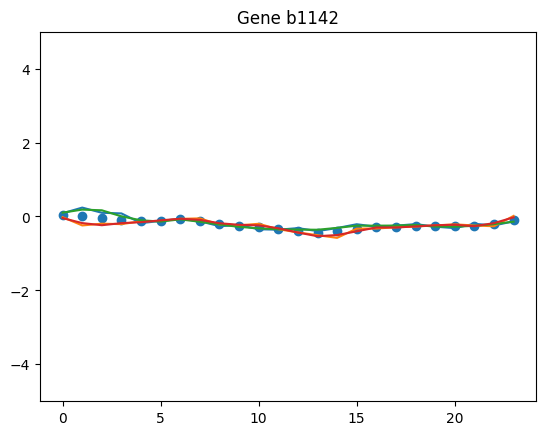

In [107]:
#Take a look at the effect of the Savitzky-Golay (5,2) filter
rnd_gene = np.random.randint(data.shape[0])

plt.plot(data[rnd_gene, :, :])
plt.plot(data_f[rnd_gene, :, :])
plt.scatter(range(24), np.mean(data_f[rnd_gene, :, :], axis=1))
plt.ylim([-5,5])
plt.title("Gene "+df.columns[rnd_gene] )
plt.show()

In [109]:
from preprocess import standardize_time_series

data_fs = standardize_time_series(data_f, data_f.shape[1], data_f.shape[2])


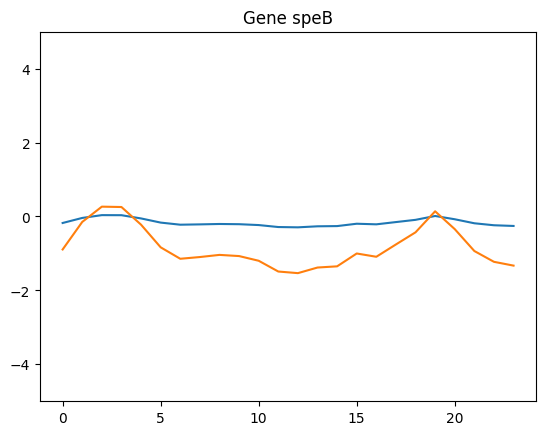

In [134]:
#Take a look at the effect of the Standardiser
rnd_gene = np.random.randint(data.shape[0])

plt.plot(data_f[rnd_gene, :, 0])
plt.plot(data_fs[rnd_gene, :, 0])
plt.ylim([-5,5])
plt.title("Gene "+df.columns[rnd_gene] )
plt.show()

In [136]:
from dmd import *

r = 10
A,Atilde,data_fc_norm_red,U_r,cd,eVals_r,eVecs_r,Phi,b_r0,b_r1 = \
        dmd(data_fs,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3) #trimThesh=2.5e-3

r2_score for n-step prediction (reduced): 8.632e-01


In [140]:
#In this section we compute the Gram matrix of the system
from sensor_placement import gram_matrix

nT = data_fs.shape[1]

G = gram_matrix(A, data_fs[:,0,:], nT = nT, reduced = False)

In [141]:
Gt, Gt_recon = gram_matrix(Atilde,data_fc_norm_red[:,0,:],nT=100,reduced=True,projection_matrix=U_r)

In [142]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
import scipy as sp

D, V = sp.linalg.eig(G,left=False,right=True)
Dt,Vt = sp.linalg.eig(Gt,left=False,right=True)
Dt_recon, Vt_recon = sp.linalg.eig(Gt_recon,left=False,right=True)

In [144]:
V[:,0:1].T.shape

(1, 1807)

In [145]:
# get gene sampling weights
# W = Vt_recon[:,0:p].T
W = V[:,0:1].T
# W = V[:,1:2].T
sorted_inds = list(np.argsort(np.abs(W[0,:]))) # based on top eigenvector only
sorted_tags = [df.columns[x] for x in sorted_inds]
Wsorted = deepcopy(W)[:,sorted_inds] # Used to generate percent rank of genes

# normalize gene sampling weights
gene_std = np.mean(np.std(data_fs,axis=2),axis=1)
Wn = W[0]/( gene_std )
sorted_inds_n = list(np.argsort(np.abs(Wn))) 
sorted_tags_n = [df.columns[x] for x in sorted_inds_n]
Wsorted_n = deepcopy(Wn)[sorted_inds_n]

# apply shrinkage to standard deviations based on sampling weights, then normalize
z, cov = np.polyfit(x=W[0], y=gene_std, deg=2, cov=True)
x_w = np.linspace(W[0].min(),W[0].max(),len(W[0]))
std_x_w = z[0]*x_w**2+z[1]*x_w+z[2]
Ws = W[0] / std_x_w # normalized via shrinkage estimated std
sorted_inds_s = list(np.argsort(np.abs(Ws))) 
sorted_tags_s = [df.columns[x] for x in sorted_inds_s]
Wsorted_s = deepcopy(Ws)[sorted_inds_s]

In [146]:
# takes several minutes to run
from sensor_placement import reconstruct_x0_sequential
import pickle

data_fc_norm = data_fs
samplingFreq = 30

doRun = False
if doRun:
    rho_T10 = reconstruct_x0_sequential(data_fc_norm,10,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top') # second argument is number of timepoints
    rho_T9 = reconstruct_x0_sequential(data_fc_norm,9,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T8 = reconstruct_x0_sequential(data_fc_norm,8,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T7 = reconstruct_x0_sequential(data_fc_norm,7,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T6 = reconstruct_x0_sequential(data_fc_norm,6,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T5 = reconstruct_x0_sequential(data_fc_norm,5,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T4 = reconstruct_x0_sequential(data_fc_norm,4,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T3 = reconstruct_x0_sequential(data_fc_norm,3,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T2 = reconstruct_x0_sequential(data_fc_norm,2,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T1 = reconstruct_x0_sequential(data_fc_norm,1,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_list = [rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1]
    
doRunRand = False
if doRunRand: 
    rho_T10_rand = reconstruct_x0_sequential(data_fc_norm,10,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T9_rand = reconstruct_x0_sequential(data_fc_norm,9,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T8_rand = reconstruct_x0_sequential(data_fc_norm,8,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T7_rand = reconstruct_x0_sequential(data_fc_norm,7,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T6_rand = reconstruct_x0_sequential(data_fc_norm,6,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T5_rand = reconstruct_x0_sequential(data_fc_norm,5,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T4_rand = reconstruct_x0_sequential(data_fc_norm,4,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T3_rand = reconstruct_x0_sequential(data_fc_norm,3,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T2_rand = reconstruct_x0_sequential(data_fc_norm,2,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T1_rand = reconstruct_x0_sequential(data_fc_norm,1,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')

doSave = False
if doSave: 
    pickle.dump([rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1],open('data/reconstructions.pkl','wb'))
#     pickle.dump([rho_T10_rand,rho_T9_rand,rho_T8_rand,rho_T7_rand,rho_T6_rand,rho_T5_rand,rho_T4_rand,rho_T3_rand,rho_T2_rand,rho_T1_rand],open('data/reconstructions_random.pkl','wb'))

if not doRun:
    rho_list = pickle.load(open('data/reconstructions.pkl','rb'))
if not doRunRand:
    rho_rand_list = pickle.load(open('data/reconstructions_random.pkl','rb'))

In [178]:
np.argmax(np.abs(W[0]))

551

In [179]:
W[0][551]

-0.043203843517951396

In [181]:
sorted_inds[1806]

551

In [177]:
list(Wsorted[0]).index[W[0][]]

[2.0508744481667823e-05,
 -2.5652913613747163e-05,
 5.0399293542692855e-05,
 -6.89917641512648e-05,
 7.545497983471627e-05,
 -8.027953246486542e-05,
 0.00011822912093713052,
 -0.00013624591431569963,
 -0.0001424078485231537,
 -0.00023445721120202685,
 0.0002354993419717161,
 -0.00025808732875582475,
 -0.00029321216002943935,
 0.00030629045482370883,
 -0.00031834497437429764,
 -0.0003751865969271211,
 0.0003962870686885167,
 0.00040685059593529134,
 0.0004667786196769823,
 0.00047026922414237387,
 -0.0005319896922699803,
 -0.0005412193196006203,
 0.0006727399842983148,
 -0.0007331833227404047,
 -0.0007359495096552365,
 -0.0007428350080577354,
 0.0008333034162553884,
 0.000836427849938091,
 -0.0008708613164569697,
 -0.0009111225458083281,
 0.0009229841188796316,
 0.0010182909024102978,
 -0.0010323493262315558,
 0.0010373050541576656,
 -0.0010622706618087059,
 0.0011057013805214411,
 0.0011110473775915088,
 -0.0011431304946715147,
 -0.0011579555977894937,
 -0.0012669268285416995,
 0.00126

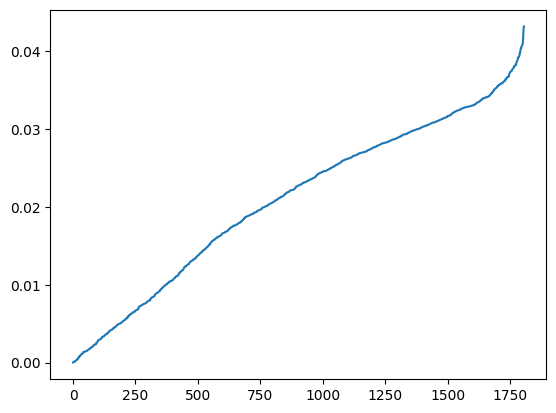

In [190]:
plt.plot(np.abs(Wsorted[0]))
plt.show()


In [219]:
np.random.seed(17)

top_genes = np.random.randint(int(np.floor(data_fc_norm.shape[0]*0.97)), data_fc_norm.shape[0], size=15)


In [217]:
sorted_inds[1799]

1029

In [218]:
W[0][1029]

-0.04079332063438432